# Building a multi-user ReAct AI Agent Chatbot with LangGraph - Prebuilt Agents

We will build AI Agents with LangGraph. We will use a pre-built agent.

Agents are systems that use an LLM as a reasoning engine to determine which actions to take and what the inputs to those actions should be. The results of those actions can then be fed back into the agent and it determines whether more actions are needed, or whether it is okay to stop.

Here we'll create a simple ReAct agent app that can search the web and check the weather. The app consists of an agent (LLM) and tools. As we interact with the app, we will first call the agent (LLM) to decide if we should use tools. Then we will run a loop:

- If the agent said to take an action (i.e. call tool), we'll run the tools and pass the results back to the agent
- If the agent did not ask to run tools, we will finish (respond to the user)



## Install OpenAI, and LangChain dependencies

Install the following httpx library version for compatibility with other libraries

In [1]:
!pip install httpx==0.27.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.16.1 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


In [2]:
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0
!pip install langgraph==0.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.1/397.1 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.1.2
    Uninstalling tenacity-9.1.2:
      Successfully uninstalled tenacity-9.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.42
    Uninstalling langsmith-0.3.42:
      Successfully uninstalled langsmith-0.3.42
  Attempting uninstall: langchain-core
    Fo

## WeatherAPI API Key

Get a free API key from [here](https://www.weatherapi.com/signup.aspx)

## Setup Environment Variables

In [21]:
from google.colab import userdata
import os

os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

WEATHER_API_KEY = userdata.get('WEATHER_API_KEY')

In [22]:
print(WEATHER_API_KEY)

9b07689c14444f8bab572157253005


## Create Tools

Here we create two custom tools which are wrappers on top of the [Tavily API](https://tavily.com/#api) and [WeatherAPI](https://www.weatherapi.com/)

- Simple Web Search tool
- Weather tool

In [23]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
import json
import requests

tv_search = TavilySearchResults(max_results=3, search_depth='advanced',
                                max_tokens=10000)

@tool
def search_web(query: str) -> list:
    """Search the web for a query."""
    results = tv_search.invoke(query)
    return results

@tool
def get_weather(query: str) -> list:
    """Search weatherapi to get the current weather."""
    base_url = "http://api.weatherapi.com/v1/current.json"
    complete_url = f"{base_url}?key={WEATHER_API_KEY}&q={query}"

    response = requests.get(complete_url)
    data = response.json()
    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"


## Test Tool Calling with LLM

In [5]:
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(model="gpt-4o", temperature=0)
tools = [search_web, get_weather]

chatgpt_with_tools = chatgpt.bind_tools(tools)

In [6]:
prompt = "who won the champions league in 2024"
response = chatgpt_with_tools.invoke(prompt)
response.tool_calls

[{'name': 'search_web',
  'args': {'query': 'Champions League 2024 winner'},
  'id': 'call_KL9LC8nHk9lageSwXGyThP7T',
  'type': 'tool_call'}]

In [7]:
prompt = "how is the weather in Bangalore today"
response = chatgpt_with_tools.invoke(prompt)
response.tool_calls

[{'name': 'get_weather',
  'args': {'query': 'Bangalore'},
  'id': 'call_DDGHhOnR6JMfuxN7DReKCJUf',
  'type': 'tool_call'}]

## Build and Test AI Agent with LangGraph Pre-built Agent

Now that we have defined the tools and the LLM, we can create the agent. We will be using a tool calling agent to bind the tools to the agent with a prompt. We will also add in the capability to store historical conversations as memory

In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

SYS_PROMPT = """Act as a helpful assistant.
                Use the tools at your disposal to perform tasks as needed.
                  - get_weather: whenever user asks get the weather of a place.
                  - search_web: whenever user asks for information on current events or if you don't know the answer.
             """
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        MessagesPlaceholder(variable_name="messages")
    ]
)

def add_sys_prompt(messages):
    return prompt_template.invoke({"messages": messages}).to_messages()


Now, we can initalize the agent with the LLM, the system prompt, and the tools.

The agent is responsible for taking in input and deciding what actions to take.

LangGraph will help us create a ReAct style agent with a built-in `create_react_agent` function. Please note that here we will use a prebuilt agent.

One of the big benefits of LangGraph is that you can easily create your own agent architectures. This is something we will look at in the next hands-on demos once you get familiar with some of the essentials of using LangGraph here.

Note that we are passing in the model `chatgpt`, not `chatgpt_with_tools`. That is because LangGraph will automatically bind the tools to the LLM under the hood using the `bind_tools` function.

This should ideally be used with an LLM which supports tool \ function calling

In [9]:
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(chatgpt, tools=tools,
                           messages_modifier=add_sys_prompt)

Let's visualize the agent architecture now

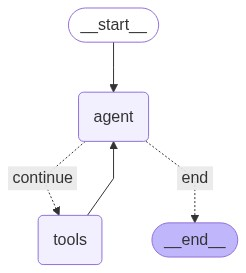

In [10]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

In [11]:
query = """Tell me who won the champions league in 2024,
            show some detailed information about the match also
        """
response = chatgpt.invoke(query)
response.content

"I'm sorry, but I don't have access to real-time data or events beyond October 2023. To find out who won the UEFA Champions League in 2024 and get detailed information about the match, I recommend checking the latest sports news websites, the official UEFA website, or other reliable sources that provide updates on football events."

In [12]:
query = """Tell me who won the champions league in 2024,
            show some detailed information about the match also
        """
response = agent.invoke({"messages": [('user', query)]})

In [13]:
response

{'messages': [HumanMessage(content='Tell me who won the champions league in 2024,\n            show some detailed information about the match also\n        ', id='3a9ecbe0-443a-4e25-9619-cb943e487b77'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Ww6WplKsj4XTJeST0EgnP3Hx', 'function': {'arguments': '{"query":"Champions League 2024 winner"}', 'name': 'search_web'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 147, 'total_tokens': 167, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-34e27797-28a2-4750-9006-9b23533ecb25-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'Champions League 2024 winner'}, 'id': 'call_Ww6WplKsj4XTJe

In [14]:
from IPython.display import display, Markdown

display(Markdown(response['messages'][-1].content))

The 2024 UEFA Champions League final was held at Wembley Stadium in London, England, on June 1, 2024. Real Madrid emerged victorious, defeating Borussia Dortmund with a score of 2-0. This victory marked Real Madrid's 15th Champions League title, further extending their record as the most successful club in the tournament's history.

### Match Details:
- **Final Score:** Real Madrid 2, Borussia Dortmund 0
- **Goals:** 
  - Dani Carvajal
  - Vinicius Junior
- **Venue:** Wembley Stadium, London
- **Date:** June 1, 2024
- **Man of the Match:** Dani Carvajal (Real Madrid)
- **Referee:** Slavko Vinčić (Slovenia)
- **Attendance:** 86,212
- **Weather:** Cloudy, 18 °C (64 °F), 54% humidity

Real Madrid's win allows them to compete against Atalanta, the winners of the 2023-24 UEFA Europa League, in the 2024 UEFA Super Cup.

In [24]:
query = """how is the weather in Bangalore today?
        """
response = agent.invoke({"messages": [('user', query)]})

In [25]:
display(Markdown(response['messages'][-1].content))

The weather in Bangalore today is characterized by light rain. The current temperature is 24.3°C (75.7°F), with a wind speed of 26.6 kph (16.6 mph) coming from the west-southwest. The humidity level is at 83%, and the visibility is around 5 kilometers. The weather feels like 26.7°C (80.0°F).

In [26]:
query = """what have we discussed so far?
        """
response = agent.invoke({"messages": [('user', query)]})

In [27]:
display(Markdown(response['messages'][-1].content))

We haven't discussed anything specific yet. If you have any questions or need assistance with something, feel free to let me know!

The agent is doing pretty well but unfortunately it doesn't remember conversations. Let's now use some memory to store this.

## Build and Test Multi-User Conversational ReAct AI Agent

We will now use `SqliteSaver` which helps to store separate conversation histories per user or session.

This will help us build a conversational Agentic Chatbot which will be accessed by many users at the same time.

While the legacy syntax uses `session_id`, in LangGraph, each user session is identified by `thread_id`

In [28]:
# removes the memory database file - usually not needed
# you can run this only when you want to remove ALL conversation histories
# ok if you get rm: cannot remove 'memory.db': No such file or directory  because initially no memory exists
!rm memory.db*

rm: cannot remove 'memory.db*': No such file or directory


In [29]:
from langgraph.checkpoint.sqlite import SqliteSaver

# used to retrieve conversation history from database
# based on a specific user or session ID
memory = SqliteSaver.from_conn_string("memory.db")

# create a conversation chain + agent which can load memory based on specific user or session id
agentic_chatbot = create_react_agent(chatgpt, tools=tools,
                                     checkpointer=memory,
                                     messages_modifier=add_sys_prompt)

# function to call the agent show results per user session (called a thread ID here)
from IPython.display import display, Markdown
def chat_with_agent(prompt: str, session_id: str):
    response = agentic_chatbot.invoke({"messages": [('user', prompt)]},
                                      {'configurable': { 'thread_id': session_id}})
    display(Markdown(response['messages'][-1].content))

Let's now simulate User 1 using the agent

In [30]:
user_id = 'john001'
prompt = "Tell me who won champions league in 2024"
chat_with_agent(prompt, user_id)

Real Madrid won the 2024 UEFA Champions League, defeating Borussia Dortmund 2-0 in the final held at Wembley Stadium in London.

In [31]:
prompt = "Tell me more about this event in detail please"
chat_with_agent(prompt, user_id)

The 2024 UEFA Champions League final was the concluding match of the 2023–24 UEFA Champions League season, marking the 69th season of Europe's premier club football tournament organized by UEFA. This final took place on June 1, 2024, at Wembley Stadium in London, England.

### Key Details:
- **Teams:** The final was contested between Real Madrid and Borussia Dortmund.
- **Result:** Real Madrid won the match 2-0.
- **Goals:** The goals for Real Madrid were scored by Dani Carvajal and Vinicius Junior.
- **Man of the Match:** Dani Carvajal was named the Man of the Match for his outstanding performance.
- **Referee:** The match was officiated by Slavko Vinčić from Slovenia.
- **Attendance:** The event was attended by 86,212 spectators.
- **Weather:** The weather during the match was cloudy with a temperature of 18 °C (64 °F) and 54% humidity.

### Significance:
- This victory marked Real Madrid's 15th Champions League title, further extending their record as the club with the most Champions League wins.
- As winners, Real Madrid earned the right to play against Atalanta, the winners of the 2023–24 UEFA Europa League, in the 2024 UEFA Super Cup.

The match was a significant event in the football calendar, showcasing top-tier European club football at one of the sport's most iconic venues.

Let's now simulate User 2 using the agent

In [32]:
user_id = 'bond007'
prompt = "how is the weather in Bangalore today? Show detailed statistics"
chat_with_agent(prompt, user_id)

The current weather in Bangalore is as follows:

- **Temperature**: 24.3°C (75.7°F)
- **Condition**: Light rain ![Light rain icon](//cdn.weatherapi.com/weather/64x64/day/296.png)
- **Feels Like**: 26.7°C (80.0°F)
- **Wind**: 16.6 mph (26.6 kph) from the WSW
- **Wind Gusts**: Up to 21.9 mph (35.2 kph)
- **Humidity**: 83%
- **Cloud Cover**: 75%
- **Pressure**: 1009.0 mb (29.8 in)
- **Precipitation**: 0.06 mm
- **Visibility**: 5.0 km (3.0 miles)
- **UV Index**: 2.7
- **Dew Point**: 19.1°C (66.3°F)

The weather is currently characterized by light rain, and the conditions are relatively humid with moderate wind speeds.

In [33]:
user_id = 'bond007'
prompt = "what about Dubai?"
chat_with_agent(prompt, user_id)

The current weather in Dubai is as follows:

- **Temperature**: 39.3°C (102.7°F)
- **Condition**: Sunny ![Sunny icon](//cdn.weatherapi.com/weather/64x64/day/113.png)
- **Feels Like**: 49.4°C (120.8°F)
- **Wind**: 12.8 mph (20.5 kph) from the West
- **Wind Gusts**: Up to 26.4 mph (42.6 kph)
- **Humidity**: 33%
- **Cloud Cover**: 0% (Clear skies)
- **Pressure**: 1000.0 mb (29.53 in)
- **Precipitation**: 0.0 mm
- **Visibility**: 10.0 km (6.0 miles)
- **UV Index**: 9.8
- **Dew Point**: 20.5°C (68.9°F)

The weather in Dubai is currently very hot and sunny, with clear skies and a high UV index. The temperature feels significantly hotter due to the heat index.

In [34]:
user_id = 'bond007'
prompt = "which city is hotter?"
chat_with_agent(prompt, user_id)

Dubai is significantly hotter than Bangalore. The current temperature in Dubai is 39.3°C (102.7°F), while in Bangalore, it is 24.3°C (75.7°F). Additionally, the "feels like" temperature in Dubai is 49.4°C (120.8°F), which is much higher than Bangalore's 26.7°C (80.0°F).